In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve,\
                                                        precision_score, recall_score, f1_score,roc_curve,auc,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict,StratifiedKFold
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
# import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance
# from collections import Counter
from data_preprocessing import preprocess_data
from data_loading import load_data
from models import cross_val_pr_curve,tune_hyperparameters

In [2]:
train_data_path="D:/Pycharm/AutoLoanModel/Training Dataset.csv"
test_data_path="D:/Pycharm/AutoLoanModel/Testing Dataset.csv"
df_train, df_test = load_data(train_data_path,test_data_path)
X_train_processed, y_train, X_test_processed, y_test=preprocess_data(df_train, df_test)

In [3]:
# Train Logistic Regression model with statsmodels (Logit and Logit)
X_train_sm = sm.add_constant(X_train_processed)


logit_model = sm.Logit(y_train, X_train_sm)
result_logit = logit_model.fit()
print("Statsmodels Logit Summary:")
print(result_logit.summary())


Optimization terminated successfully.
         Current function value: 0.402543
         Iterations 7
Statsmodels Logit Summary:
                           Logit Regression Results                           
Dep. Variable:              aprv_flag   No. Observations:                21606
Model:                          Logit   Df Residuals:                    21564
Method:                           MLE   Df Model:                           41
Date:                Mon, 31 Mar 2025   Pseudo R-squ.:                  0.2997
Time:                        11:19:25   Log-Likelihood:                -8697.3
converged:                       True   LL-Null:                       -12419.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
con

In [6]:
# remove feature that are not significant according to P-value
X_train_processed_filtered_pvalue=X_train_processed.loc[:,(result_logit.pvalues<=0.05)[1:].values]

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_sm.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i)
                          for i in range(len(X_train_sm.columns))]

print(vif_data)

D:\Pycharm\myenv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
D:\Pycharm\myenv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                              feature        VIF
0                                               const   0.000000
1                                           num__fico   4.541138
2                               num__amtfinanced_1req   1.356392
3                                       num__pti_1req   1.201221
4                                       num__ltv_1req   1.148805
5                                  num__p12_reh7120_a   3.598577
6                                  num__p12_bcx7110_a   2.856047
7                                  num__p12_all7170_a   1.359487
8                                  num__p12_aut7110_a   1.131603
9                                  num__p12_all7120_a   1.645483
10                                 num__p12_all7937_a   5.561706
11                                 num__p12_bcc8120_a   2.120490
12                                 num__p12_iln7410_a   1.664149
13                                 num__p12_rev1300_a   5.456965
14                       

In [3]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'fit_intercept':[True,False],
    'class_weight':['balanced']
}

best_params=tune_hyperparameters(X_train_processed,y_train,param_grid,LogisticRegression(),'average_precision')

print("Best Hyperparameters for Logistic Regression:", best_params)


Best Hyperparameters for Logistic Regression: {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}


In [4]:
# Train Logistic Regression model with best hyperparameters
log_reg = LogisticRegression(**best_params_lr)
log_reg.fit(X_train_processed, y_train);

Cross-Validation Precision Scores: [0.92411977 0.92679127 0.92825977]
Mean Precision Score: 0.9263902678882192
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.77      0.63      5654
           1       0.90      0.76      0.83     15952

    accuracy                           0.77     21606
   macro avg       0.72      0.77      0.73     21606
weighted avg       0.81      0.77      0.78     21606



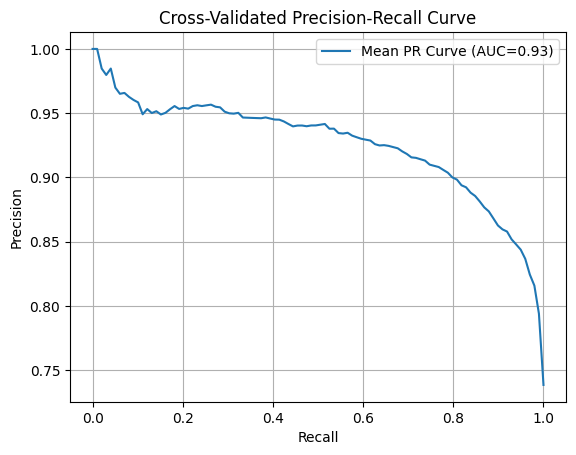

Mean Precision-Recall AUC: 0.9264


In [5]:
from models import evaluate_models
evaluate_models(log_reg, X_train_processed, y_train,'average_precision')

**Feature Importance Using Permuatiuon**


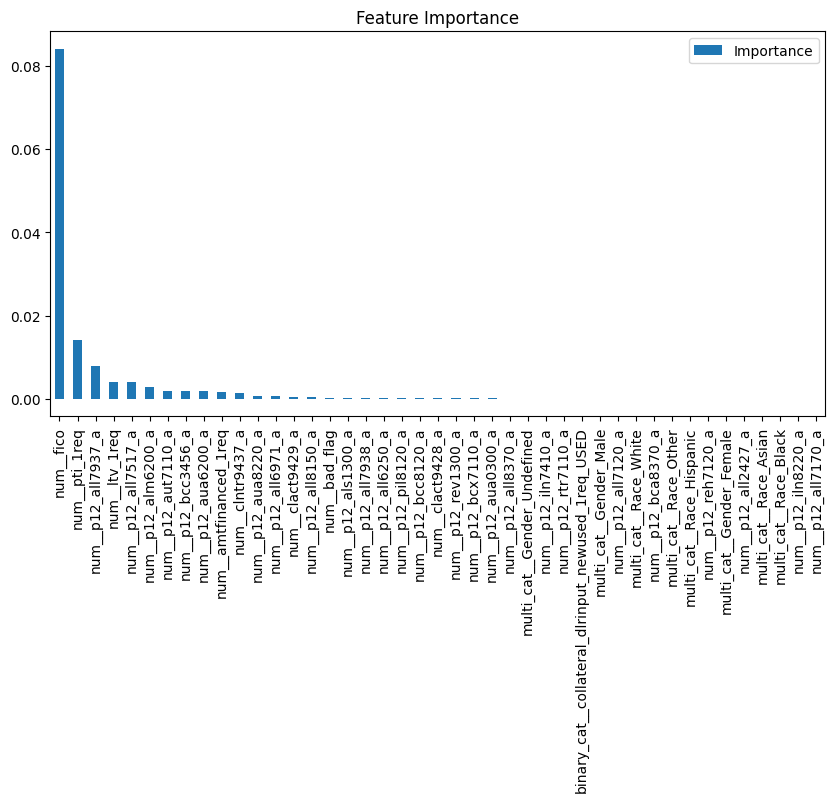

In [5]:
from models import feature_importance
feature_importance(log_reg, X_train_processed, y_train,'average_precision')